# Classify Handwritten Digits with Convolutional Neural Networks (CNNs)
By B Nord (2018 Nov 09)  
Minor updates by G Hosseinzadeh (2025 May 19)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
from sklearn.metrics import ConfusionMatrixDisplay
import keras

## Prepare the Data

### Download the data
Load the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set included in Keras. This consists of handwritten digits from 0-9 that we will try to identify with a CNN.

In [2]:
# uncomment the following line if the load_data function crashes with SSL: CERTIFICATE_VERIFY_FAILED
# !curl https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz -o ~/.keras/datasets/mnist.npz

(x_train_temp, y_train_temp), (x_test_temp, y_test_temp) = keras.datasets.mnist.load_data()

In [3]:
print(y_train_temp)

[5 0 4 ... 5 6 8]


### **Look** at the data
Check whether the shapes of 'data' and 'label' (for train and test, respectively) match. If they don't now, Keras/TF will kindly yell at you later. (You always do this so that you **know** what the structure is!)

In [4]:
print("Train Data Shape:", x_train_temp.shape)
print("Test Data Shape:", x_test_temp.shape)
print("Train Label Shape:", y_train_temp.shape)
print("Test Label Shape:", y_test_temp.shape)

Train Data Shape: (60000, 28, 28)
Test Data Shape: (10000, 28, 28)
Train Label Shape: (60000,)
Test Label Shape: (10000,)


Print out an example image and label from in the training set. Can you see the pattern of the number? Plot the first two images in the set.


5 0


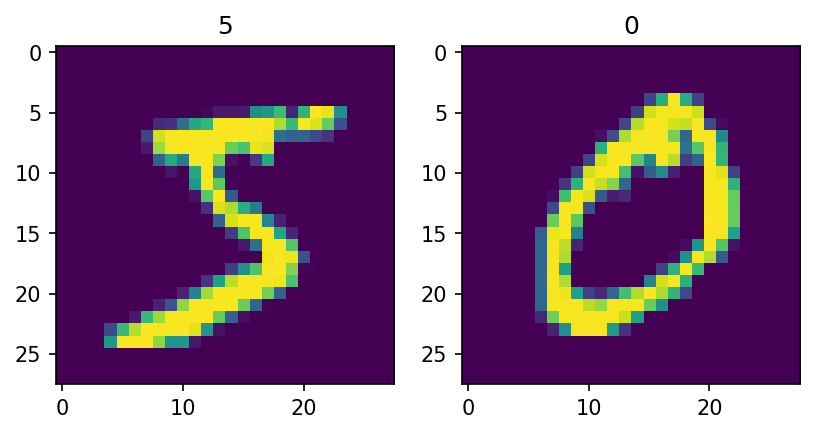

In [5]:
print(y_train_temp[0], y_train_temp[1])

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_train_temp[0])
ax[0].set_title(y_train_temp[0])
ax[1].imshow(x_train_temp[1])
ax[1].set_title(y_train_temp[1])
plt.show()

### Prepare the data

Data often need to be reshaped and normalized for ingestion into the neural network.
Add an extra (empty) dimension to the end of the images (see `np.expand_dims`).
Normalize the pixel values to be between 0 and 1 for the network.



In [6]:
x_train = np.expand_dims(x_train_temp, 3)
x_test = np.expand_dims(x_test_temp, 3)
x_train= np.divide(x_train, x_train.max(1).max(1)[0])
x_test= np.divide(x_test, x_test.max(1).max(1)[0])

Apply *one-hot encoding* to the labels.


1.   The current encoding provides a literal label. For example, the label for "3"  is `3`.
2.   One-hot encoding places a "1" in an array at the appropriate location for that datum. For example, the label "3" becomes `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.

This increases the efficiency of the matrix algebra during network training and evaluation.




In [7]:
y_train = keras.utils.to_categorical(y_train_temp)
y_test = keras.utils.to_categorical(y_test_temp)

## Design Neural Network Architecture!

### Select model format and add layers to the model sequentially
Create a sequential model with the following layers:
1. input layer with the shape of one of the input images
2. 2D convolution layer with 32 filters, a kernel size of (3, 3), and a ReLU activation function
3. dropout layer with a rate of 0.25 and a ReLU activation function
4. flattening layer
5. fully connected (dense) layer with a neuron for each convolution filter
6. dropout layer with a rate of 0.5
7. output fully connected (dense) layer with a neuron for each classification and a softmax activation function

Print out the model summary table.

In [8]:
inputs = keras.Input(shape=(28,28,1))
convolution = keras.layers.Convolution2D(filters=32, kernel_size=3, activation='relu')(inputs)
dropout = keras.layers.Dropout(rate=0.24)(convolution) #I get an error when I try to use activation='relu', saying that that is not a valid kwarg
flattening = keras.layers.Flatten()(dropout)
dense = keras.layers.Dense(units=32)(flattening)
dropout_2 = keras.layers.Dropout(0.5)(dense)
outputs = keras.layers.Dense(units=10, activation='softmax')(dropout_2)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       692,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,906 (2.64 MB)

 Trainable params: 692,906 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

Select three key options
1.   **optimizer**: the method for optimizing the weights. "Stochastic Gradient Descent (SGD)" is the canonical method.
2.   **loss** function: the form of the function to encode the difference between the data's true label and the predict label.
3.   **metric**: the function by which the model is evaluated.

In [9]:
model.compile(optimizer="sgd", loss = keras.losses.MeanSquaredError(), metrics=["accuracy"])

### Fit (read: Train) the model
Use 5 epochs (batches) of 32 images and a validation split of 80%.

In [10]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.8, verbose=1)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1545 - loss: 0.0892 - val_accuracy: 0.4569 - val_loss: 0.0860
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3783 - loss: 0.0847 - val_accuracy: 0.5289 - val_loss: 0.0797
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4864 - loss: 0.0775 - val_accuracy: 0.5777 - val_loss: 0.0698
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5639 - loss: 0.0681 - val_accuracy: 0.6695 - val_loss: 0.0583
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6449 - loss: 0.0576 - val_accuracy: 0.7519 - val_loss: 0.0480


## Diagnostics!


#### Evaluate overall model efficacy

Evaluate model on training and test data and compare. This provides summary values that are equivalent to the final value in the accuracy plot below.  Don't forget to undo the one-hot encoding for the predicted labels *(hint: `np.argmax`)*.

In [11]:
predictions = model.predict(x_test, batch_size=32, verbose=1)
predictions = np.argmax(predictions, 1)
y_test_non_onehot = np.argmax(y_test, 1)

acc_train = history.history['val_accuracy'][4]
acc_test = (predictions == y_test_non_onehot).sum() / len(y_test_non_onehot)

print(f'Train accuracy = {acc_train:.1%}')
print(f'Test accuracy = {acc_test:.1%}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train accuracy = 75.2%
Test accuracy = 76.4%


#### Plot accuracy and loss as a function of epochs (equivalently training time)
This information is stored in the `history` object you defined earlier.

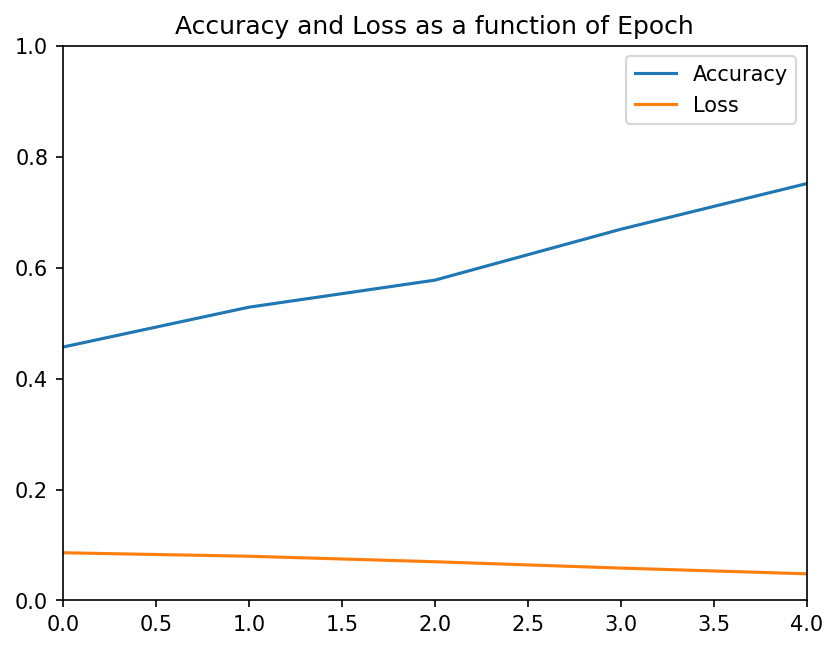

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot(history.history['val_accuracy'], label="Accuracy")
ax.plot(history.history['val_loss'], label="Loss")
ax.legend()
ax.set_title("Accuracy and Loss as a function of Epoch")
ax.set_xlim([0, 4])
ax.set_ylim([0, 1.0])
plt.show()

#### Confusion Matrix
Plot a confusion matrix for the test data.

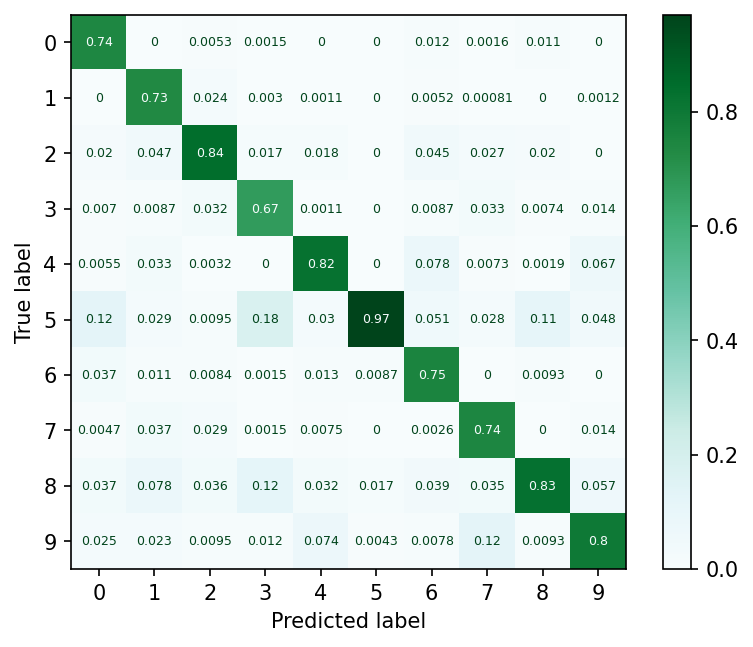

In [13]:
display = ConfusionMatrixDisplay.from_predictions(y_test_non_onehot,
                                                  predictions,
                                                  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                                  cmap = plt.cm.BuGn,
                                                  normalize='pred',
                                                  text_kw={'fontsize': 6})
plt.show()

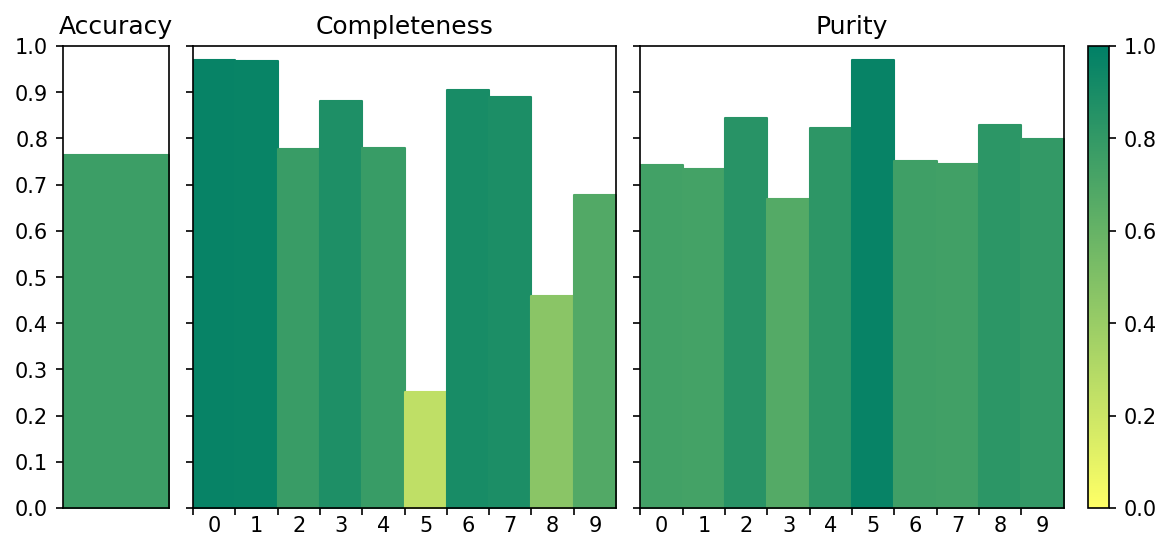

In [14]:
from matplotlib.cm import ScalarMappable
def accuracy(predicted: list, real: list):
    return np.sum(predicted == real) / len(real)

def completeness(predicted: list, real: list, classes):
    completeness_values = dict()
    for i, class_name in enumerate(classes):
        completeness_values[class_name] = np.bitwise_and(predicted == real,  predicted == i).sum() / (real == i).sum()
    return completeness_values

def purity(predicted: list, real: list, classes):
    predicted_values = dict()
    for i, class_name in enumerate(classes):
        predicted_values[class_name] = np.bitwise_and(predicted == real,  predicted == i).sum() / (predicted == i).sum()
    return predicted_values

def print_acp(title: str, predicted: list, real: list, classes):
    a = accuracy(predicted, real)
    c = completeness(predicted, real, classes)
    p = purity(predicted, real, classes)
    #print(f'{title}:\n\taccuracy\t= {a}\n\tcompleteness\t= {c}\n\tpurity\t\t= {p}')
    return (a, c, p)
a, c, p = print_acp("Number Recognition", predictions, y_test_temp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

cm = plt.cm.summer_r

fig, ax = plt.subplots(1, 4, width_ratios=[1, 4, 4, 0.2], figsize=(9, 4))
fig.subplots_adjust(wspace=0.1)
ax[0].fill_between([0, 1], a, 0, color=cm(a))
ax[0].yaxis.set_ticks(np.linspace(0, 1.0, num=11, endpoint=True))
ax[0].set_title("Accuracy")
ax[0].xaxis.set_ticks([])
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])

#draw confusion levels.
for (key, val) in zip(c.keys(), c.values()):
    ax[1].fill_between([key, key+1], val, 0, color=cm(val))
ax[1].set_title("Completeness")

#draw purity levels
for (key, val) in zip(p.keys(), p.values()):
    ax[2].fill_between([key, key+1], val, 0, color=cm(val))
ax[2].set_title("Purity")

#fix axes labels
for i in (1,2):
    ax[i].sharey(ax[0])
    ax[i].set_xlim([0, 10])
    ax[i].set_ylim([0, 1])
    ax[i].xaxis.set_ticks(range(10))
    ax[i].set_xticklabels('')
    ax[i].set_xticks([i + 0.5 for i in range(10)], minor=True)
    ax[i].set_xticklabels(range(10), minor=True)
    ax[i].tick_params(axis='x', which='minor', length=0)
    for tick in ax[i].yaxis.get_ticklabels():
        tick.set_visible(False)
fig.colorbar(mappable=ScalarMappable(None, cmap=cm), cax=ax[3])
plt.show()

*This seems to make sense. I would expect a fair bit of confusion between 3 and 5, 3 and 8, and 4 and 9. I'm not sure why it is predicting so few 5s though.*